In [4]:
import os
gee_files = [f for f in os.listdir('../Data/GEE') if f.endswith('.csv')]
print(gee_files)

['dewpoint_temperature_2m.csv', 'evaporation_from_vegetation_transpiration_sum.csv', 'potential_evaporation_sum.csv', 'prcp.csv', 'skin_temperature.csv', 'snow_depth.csv', 'snow_depth_water_equivalent.csv', 'soil_temperature_level_1.csv', 'soil_temperature_level_2.csv', 'soil_temperature_level_3.csv', 'soil_temperature_level_4.csv', 'srad.csv', 'sub_surface_runoff_sum.csv', 'surface_latent_heat_flux_sum.csv', 'surface_net_solar_radiation_sum.csv', 'surface_net_thermal_radiation_sum.csv', 'surface_pressure.csv', 'surface_runoff_sum.csv', 'surface_solar_radiation_downwards_sum.csv', 'temperature_2m.csv', 'tmax.csv', 'tmin.csv', 'total_precipitation_sum.csv', 'u_component_of_wind_10m.csv', 'volumetric_soil_water_layer_1.csv', 'volumetric_soil_water_layer_2.csv', 'vp.csv', 'v_component_of_wind_10m.csv']


In [1]:
import os
import pandas as pd

# Paths
gee_folder = '../Data/GEE'
discharge_folder = '../Data/Discharge'
output_folder = '../Data/Required Data'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get list of GEE files
gee_files = [f for f in os.listdir(gee_folder) if f.endswith('.csv')]

# Extract column identifiers from GEE files
gee_column_identifiers = [col for col in pd.read_csv(os.path.join(gee_folder, gee_files[0])).columns if col.isdigit()]

# Process each column identifier
for col_id in gee_column_identifiers:
    # Initialize a dataframe for this column identifier
    combined_data = pd.DataFrame()

    # Add Date column from any GEE file (Dates will be consistent across GEE files)
    first_gee_file = pd.read_csv(os.path.join(gee_folder, gee_files[0]))
    combined_data['Date'] = pd.to_datetime(first_gee_file['Date'], errors='coerce')

    # Load discharge file corresponding to the column identifier
    discharge_file_path = next((f for f in os.listdir(discharge_folder) if f.startswith(f"{col_id}. ")), None)
    
    if not discharge_file_path:
        print(f"No discharge file found for column {col_id}")
        continue

    discharge_data = pd.read_csv(os.path.join(discharge_folder, discharge_file_path))
    discharge_data['Date'] = pd.to_datetime(discharge_data['Date'], errors='coerce')
    discharge_data['Q (ft3/s)'] = discharge_data['Q (ft3/s)'].str.replace(',', '', regex=True).astype(float, errors='ignore')
    discharge_data.rename(columns={'Q (ft3/s)': 'Discharge'}, inplace=True)

    # Merge Discharge data with the Date column from GEE files
    combined_data = pd.merge(combined_data, discharge_data[['Date', 'Discharge']], on='Date', how='left')

    # Add GEE parameters to the dataframe
    for gee_file in gee_files:
        param_name = os.path.splitext(gee_file)[0]  # Extract parameter name from file
        gee_data = pd.read_csv(os.path.join(gee_folder, gee_file))
        gee_data['Date'] = pd.to_datetime(gee_data['Date'], errors='coerce')

        # Merge with the combined dataframe based on Date
        combined_data = pd.merge(combined_data, gee_data[['Date', col_id]].rename(columns={col_id: param_name}),
                                 on='Date', how='left')

    # Save the combined data to a new CSV file
    output_path = os.path.join(output_folder, f'{col_id}.csv')
    combined_data.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

print("Processing complete!")


Saved: ../Data/Required Data\5.csv
Saved: ../Data/Required Data\6.csv
Saved: ../Data/Required Data\7.csv
Saved: ../Data/Required Data\8.csv
Saved: ../Data/Required Data\10.csv
Saved: ../Data/Required Data\11.csv
Processing complete!


In [2]:
def look_multi_colinear(num):
    import seaborn as sns
    import matplotlib.pyplot as plt
    # Load the dataset
    file_path = f'../Data/Required Data/{num}.csv'  # Example file
    data = pd.read_csv(file_path)

    # Preprocessing for correlation analysis
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data['day_of_year'] = data['Date'].dt.dayofyear  # Add day of year as a feature
    data['month'] = data['Date'].dt.month  # Add month as a feature
    data['week'] = data['Date'].dt.isocalendar().week  # Add week as a feature

    # Drop the original Date column (if not needed) and rows with missing Discharge
    data.drop(columns=['Date'], inplace=True)
    data_clean = data.dropna(subset=['Discharge'])  # Only use rows with Discharge for correlation analysis

    # Select only numeric columns
    numeric_data = data_clean.select_dtypes(include=['number'])

    # Compute correlation matrix
    correlation_matrix = numeric_data.corr()

    # Extract pairs with high correlations
    high_corr_pairs = correlation_matrix.unstack().reset_index()
    high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

    # Filter out duplicate pairs and self-correlations
    high_corr_pairs = high_corr_pairs[
        (high_corr_pairs['Feature1'] != high_corr_pairs['Feature2']) &
        (abs(high_corr_pairs['Correlation']) > 0.95)
    ].drop_duplicates(subset=['Correlation'])

    # Sort by absolute correlation value
    high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

    # Display the pairs
    print("Highly Correlated Feature Pairs (|Correlation| > 0.95):")
    print(high_corr_pairs)

    # Save the result to a CSV file
    #high_corr_pairs.to_csv('../Data/Required Data/high_correlation_pairs.csv', index=False)

    # Plot correlation heatmap for visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=False,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        square=True,
        linewidths=0.5
    )
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'../Figures/{num}_corr_heatmap.png')


In [3]:
def clean_correlated(num):
    import pandas as pd
    # Load the dataset
    file_path = f'../Data/Required Data/{num}.csv'  # Example file
    data = pd.read_csv(file_path)

    # Columns to remove
    columns_to_remove = [
        'dewpoint_temperature_2m',
        'soil_temperature_level_1',
        'soil_temperature_level_2',
        'soil_temperature_level_3',
        'temperature_2m',
        'tmin',
        'month',
        'week',
        'volumetric_soil_water_layer_2'
    ]

    # Preprocessing for feature removal
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data['day_of_year'] = data['Date'].dt.dayofyear  # Add day of year as a feature

    # Drop the specified columns
    data_cleaned = data.drop(columns=columns_to_remove, errors='ignore')

    # Save the cleaned dataset
    output_path = f'../Data/Required Data/{num}_cleaned.csv'
    data_cleaned.to_csv(output_path, index=False)

    print(f"Cleaned dataset saved to {output_path}")


In [4]:
def do_machine_learning(num):
    import pandas as pd
    from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

    # Step 1: Load the Cleaned Dataset
    file_path = f'../Data/Required Data/{num}_cleaned.csv'  # Cleaned dataset path
    data = pd.read_csv(file_path)

    data.drop(columns=['Date'], inplace=True)
    # Ensure Discharge is numeric
    data['Discharge'] = pd.to_numeric(data['Discharge'], errors='coerce')
    # Drop Date column if not needed

    # Step 3: Setup PyCaret Regression Environment
    # Only use rows with valid 'Discharge' for training
    train_data = data.dropna(subset=['Discharge'])

    print("Setting up PyCaret environment...")
    regression_setup = setup(
        data=train_data,
        target='Discharge',
        session_id=42,
        normalize=True,        # Normalize features
        feature_selection=True, # Perform feature selection
        log_experiment=False,  # Disable experiment logging
    )

    # Step 4: Compare Models
    print("Comparing models...")
    best_model = compare_models()

    # Step 5: Tune the Best Model
    print("Tuning the best model...")
    tuned_model = tune_model(best_model)

    # Step 6: Finalize the Model
    print("Finalizing the model...")
    final_model = finalize_model(tuned_model)

    # Step 7: Evaluate Model
    # Residual Plot
    print("Generating residual plot...")
    plot_model(final_model, plot='residuals', save=True)

    # Feature Importance Plot
    print("Generating feature importance plot...")
    plot_model(final_model, plot='feature', save=True)

    # Step 8: Predict Missing Values
    # Predict Discharge for rows with missing target values
    missing_data = data[data['Discharge'].isnull()]  # Extract rows with missing Discharge
    missing_data.drop(columns = ['Discharge'], inplace = True)
    print("Predicting missing values...")
    predicted = predict_model(final_model, data=missing_data)

    # Assign predictions to the missing Discharge column
    if 'prediction_label' in predicted.columns:
        missing_data['Discharge'] = predicted['prediction_label']
    else:
        print(predicted.head())  # Debugging: Show a sample of the output
        raise KeyError("No valid prediction column ('prediction_label') found in the output of predict_model.")

    # Combine predicted rows with the original dataset
    filled_data = pd.concat([train_data, missing_data]).sort_index()

    # Save the filled dataset
    filled_data.to_csv(f'../Data/Required Data/{num}_filled.csv', index=False)
    print(f"Saved the filled dataset as '../Data/Required Data/{num}_filled.csv'")

In [5]:
def making_filled_plots(num):
    # File paths
    cleaned_file = f'../Data/Required Data/{num}_cleaned.csv'
    filled_file = f'../Data/Required Data/{num}_filled.csv'

    # Load datasets
    cleaned_data = pd.read_csv(cleaned_file)  # Original cleaned data with 'Date'
    filled_data = pd.read_csv(filled_file)    # Filled data without 'Date'

    # Ensure Discharge column is numeric in both datasets
    cleaned_data['Discharge'] = pd.to_numeric(cleaned_data['Discharge'], errors='coerce')
    filled_data['Discharge'] = pd.to_numeric(filled_data['Discharge'], errors='coerce')

    # Check for remaining invalid or missing values in observed and filled datasets
    #invalid_observed = cleaned_data[cleaned_data['Discharge'].isnull()]
    #invalid_filled = filled_data[filled_data['Discharge'].isnull()]

    # Print the number of invalid rows in each dataset
    #print(f"Invalid rows in observed data: {len(invalid_observed)}")
    #print(f"Invalid rows in filled data: {len(invalid_filled)}")

    # Plotting (after ensuring 'Date' column exists in filled_data)
    filled_data['Date'] = cleaned_data['Date']  # Add Date from cleaned_data if missing
    filled_data['Date'] = pd.to_datetime(filled_data['Date'], errors='coerce')
    cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], errors='coerce')

    # Separate observed and filled data
    observed_data = cleaned_data
    filled_data_nonnull = filled_data

    # Plotting
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(observed_data['Date'], observed_data['Discharge'], label='Observed Data', marker='o', linestyle='-', alpha=0.7)
    plt.plot(filled_data_nonnull['Date'], filled_data_nonnull['Discharge'], label='Machine Learning Prediction', marker='x', linestyle='--', alpha=0.7)
    plt.title('Observed vs. Filled Discharge Time Series')
    plt.xlabel('Date')
    plt.ylabel('Discharge')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Save the plot
    plot_path = f'../Figures/{num}Observed_vs_Filled_Discharge_Cleaned.png'
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"Time series plot saved to: {plot_path}")


Highly Correlated Feature Pairs (|Correlation| > 0.95):
                            Feature1                               Feature2  \
143                 skin_temperature                         temperature_2m   
161                       snow_depth            snow_depth_water_equivalent   
897                      day_of_year                                  month   
452  surface_net_solar_radiation_sum  surface_solar_radiation_downwards_sum   
225         soil_temperature_level_1               soil_temperature_level_2   
131                 skin_temperature               soil_temperature_level_1   
236         soil_temperature_level_1                         temperature_2m   
145                 skin_temperature                                   tmin   
610                   temperature_2m                                   tmin   
21           dewpoint_temperature_2m                                   tmin   
609                   temperature_2m                                   tmax

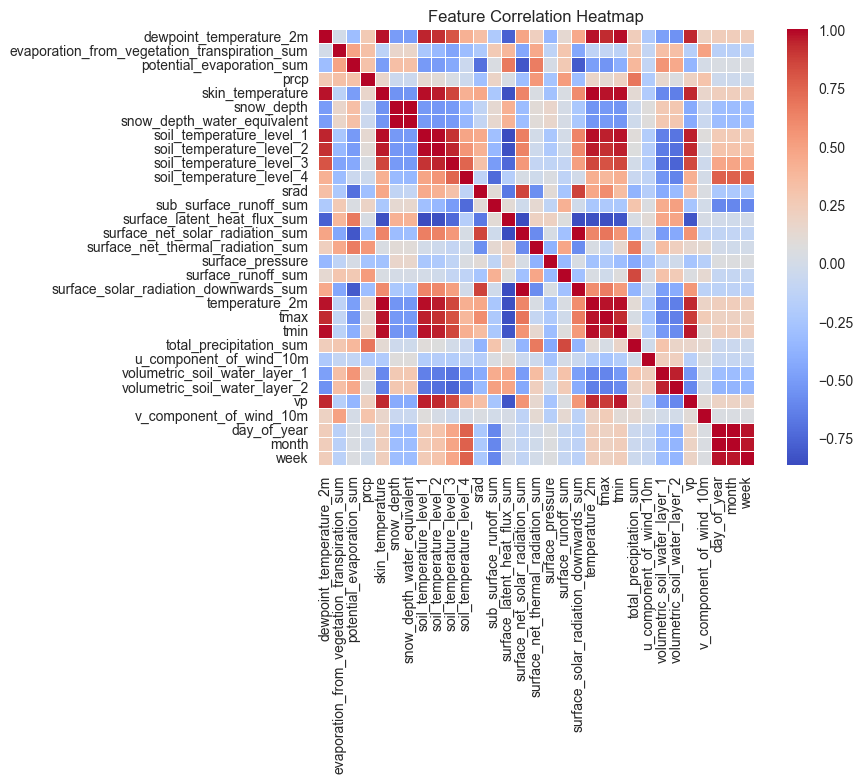

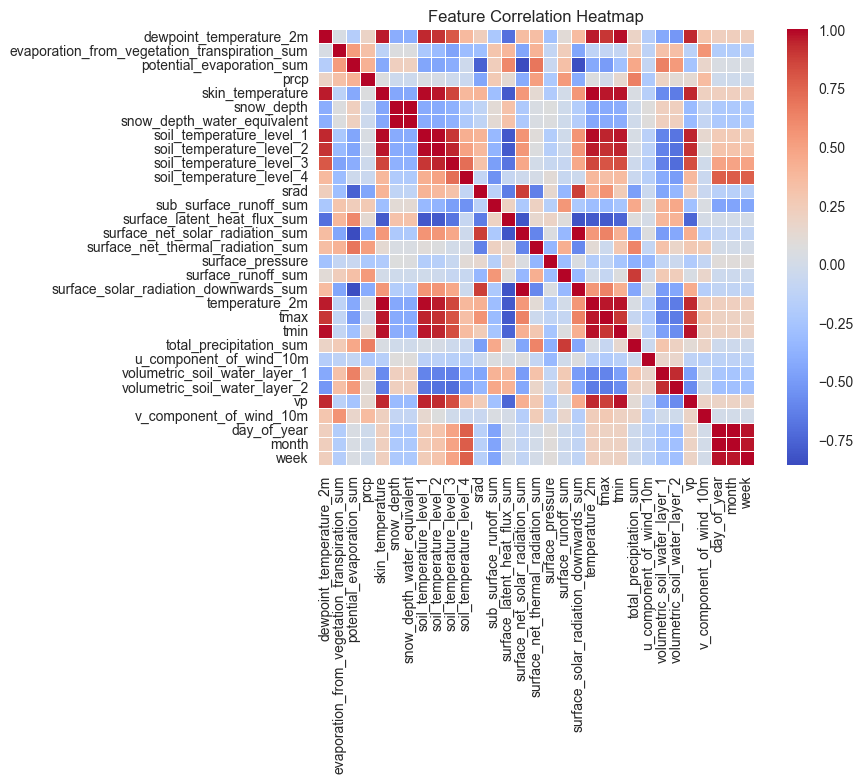

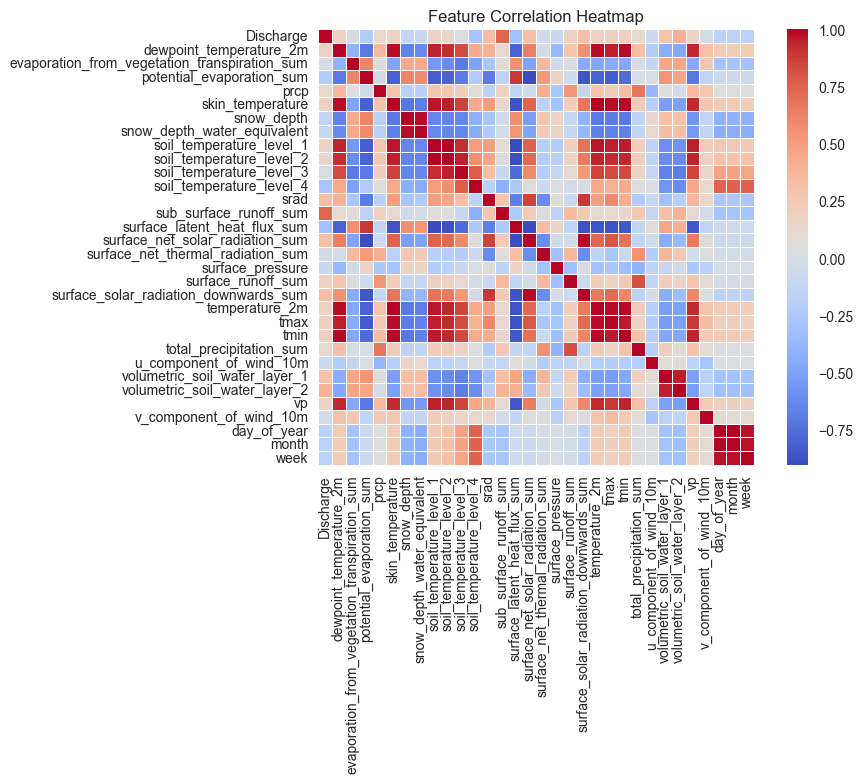

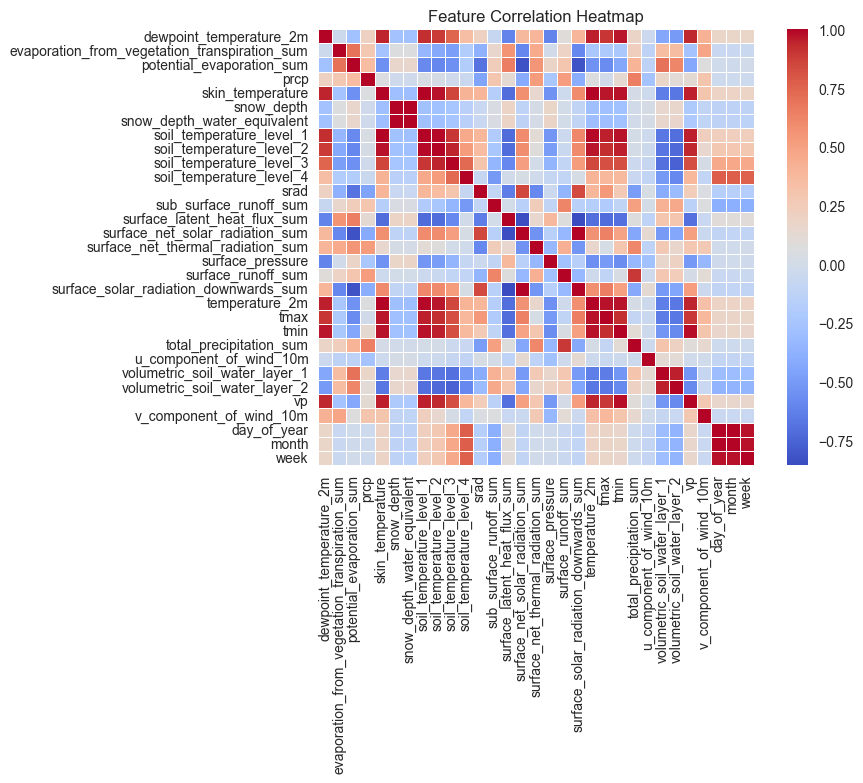

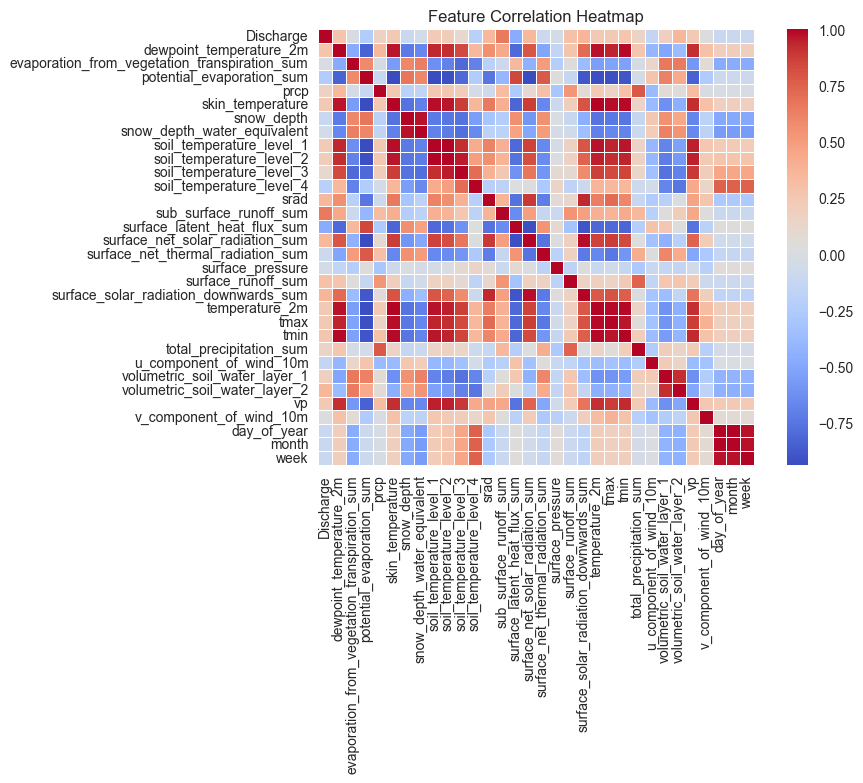

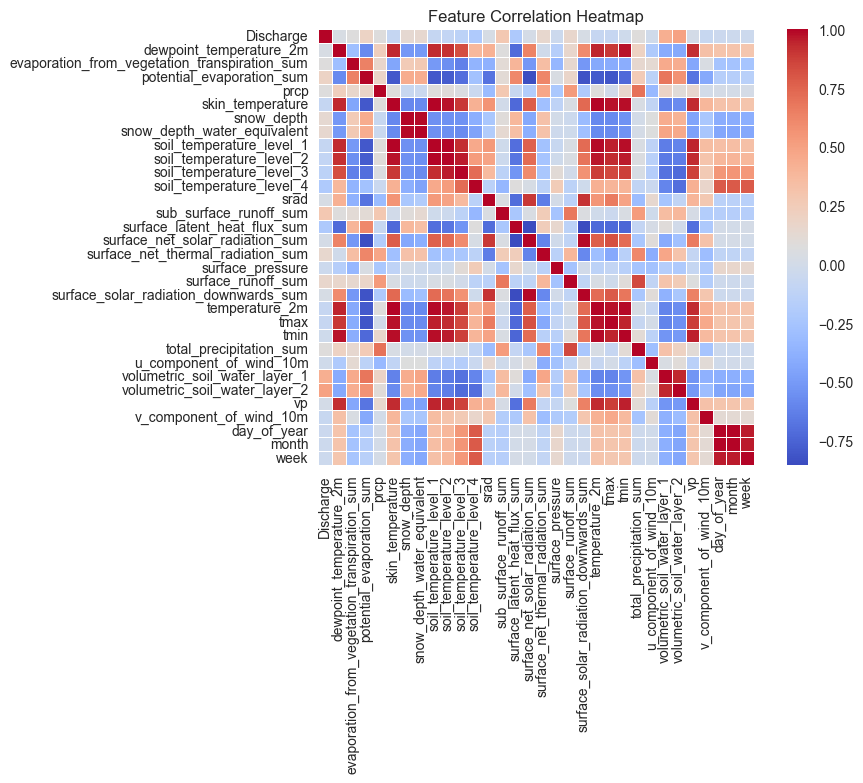

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

numbers = ['5','6', '7', '8', '10', '11']
for num in numbers:
    look_multi_colinear(num)

In [7]:
numbers = ['5','6', '7', '8', '10', '11']
for num in numbers:
    clean_correlated(num)

Cleaned dataset saved to ../Data/Required Data/5_cleaned.csv
Cleaned dataset saved to ../Data/Required Data/6_cleaned.csv
Cleaned dataset saved to ../Data/Required Data/7_cleaned.csv
Cleaned dataset saved to ../Data/Required Data/8_cleaned.csv
Cleaned dataset saved to ../Data/Required Data/10_cleaned.csv
Cleaned dataset saved to ../Data/Required Data/11_cleaned.csv


In [8]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

# Step 1: Load the Cleaned Dataset
file_path = '../Data/Required Data/5_cleaned.csv'  # Cleaned dataset path
data = pd.read_csv(file_path)

data.drop(columns=['Date'], inplace=True)
# Ensure Discharge is numeric
data['Discharge'] = pd.to_numeric(data['Discharge'], errors='coerce')
  # Drop Date column if not needed

# Step 3: Setup PyCaret Regression Environment
# Only use rows with valid 'Discharge' for training
train_data = data.dropna(subset=['Discharge'])

print("Setting up PyCaret environment...")
regression_setup = setup(
    data=train_data,
    target='Discharge',
    session_id=42,
    normalize=True,        # Normalize features
    feature_selection=True, # Perform feature selection
    log_experiment=False,  # Disable experiment logging
)

# Step 4: Compare Models
print("Comparing models...")
best_model = compare_models()

# Step 5: Tune the Best Model
print("Tuning the best model...")
tuned_model = tune_model(best_model)

# Step 6: Finalize the Model
print("Finalizing the model...")
final_model = finalize_model(tuned_model)

# Step 7: Evaluate Model
# Residual Plot
print("Generating residual plot...")
plot_model(final_model, plot='residuals', save=True)

# Feature Importance Plot
print("Generating feature importance plot...")
plot_model(final_model, plot='feature', save=True)



Setting up PyCaret environment...


,Description,Value
0,Session id,42
1,Target,Discharge
2,Target type,Regression
3,Original data shape,"(3715, 23)"
4,Transformed data shape,"(3715, 5)"
5,Transformed train set shape,"(2600, 5)"
6,Transformed test set shape,"(1115, 5)"
7,Numeric features,22
8,Rows with missing values,0.1%
9,Preprocess,True


Comparing models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,54885.6300,7053244082.5100,83568.0454,0.8809,0.2701,0.2157,0.1340
xgboost,Extreme Gradient Boosting,63410.6258,8864499968.0000,93870.7758,0.8503,0.2940,0.2391,0.2210
catboost,CatBoost Regressor,66176.8098,8932701878.2136,94124.5527,0.8494,0.2968,0.2507,0.3630
rf,Random Forest Regressor,63605.8277,8962408452.7192,94353.5927,0.8486,0.2943,0.2415,0.1520
lightgbm,Light Gradient Boosting Machine,69290.8177,9922395329.2040,99314.5920,0.8323,0.3101,0.2616,0.2240
knn,K Neighbors Regressor,78361.9844,12555371417.6000,111742.7133,0.7876,0.3516,0.3034,0.1160
gbr,Gradient Boosting Regressor,83602.7086,13298971524.2669,114996.4313,0.7755,0.3541,0.3143,0.1450
dt,Decision Tree Regressor,74212.6538,15231408588.4615,122818.3954,0.7413,0.3786,0.2793,0.1140
ada,AdaBoost Regressor,118692.3961,20380221314.9227,142565.3570,0.6550,0.5262,0.5891,0.1230
ridge,Ridge Regression,106919.9919,21171799229.7640,145340.7426,0.6415,0.4876,0.4042,0.3410


Tuning the best model...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,81155.8427,11835335956.7429,108790.3303,0.8043,0.3456,0.3102
1,80671.2066,12541369687.1477,111988.2569,0.7993,0.3512,0.2969
2,77978.5897,10776937865.3658,103812.0314,0.7901,0.3486,0.3152
3,84113.6663,13800955129.9666,117477.4665,0.7574,0.3516,0.3193
4,74423.6201,10612416203.7911,103016.5822,0.8103,0.3361,0.3030
5,77833.1201,11417398283.6982,106852.2264,0.8060,0.3148,0.2805
6,81268.4350,12040938858.9725,109731.2119,0.7928,0.3107,0.2737
7,90386.1520,16142178405.2562,127051.8729,0.7398,0.3909,0.3606
8,87391.1128,12692647530.3097,112661.6507,0.7744,0.3654,0.3465


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Finalizing the model...
Generating residual plot...


Generating feature importance plot...


'Feature Importance.png'

In [9]:
# Step 8: Predict Missing Values
# Predict Discharge for rows with missing target values
missing_data = data[data['Discharge'].isnull()]  # Extract rows with missing Discharge

if missing_data.empty:
    print("No missing values to predict.")
else:
    missing_data.drop(columns = ['Discharge'], inplace = True)
    print("Predicting missing values...")

    # Use PyCaret's predict_model to predict missing values
    predicted = predict_model(final_model, data=missing_data)

    # Check for the prediction column and assign values
    if 'prediction_label' in predicted.columns:
        missing_data['Discharge'] = predicted['prediction_label']
    else:
        print(predicted.head())  # Debugging: Show a sample of the output
        raise KeyError("No valid prediction column ('prediction_label') found in the output of predict_model.")

    # Combine predicted rows with the original dataset
    filled_data = pd.concat([train_data, missing_data]).sort_index()

    # Save the filled dataset
    filled_data.to_csv('../Data/Required Data/5_filled.csv', index=False)
    print("Saved the filled dataset as '../Data/Required Data/5_filled.csv'")


Predicting missing values...


Saved the filled dataset as '../Data/Required Data/5_filled.csv'


In [10]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

# Step 1: Load the Cleaned Dataset
file_path = '../Data/Required Data/6_cleaned.csv'  # Cleaned dataset path
data = pd.read_csv(file_path)

data.drop(columns=['Date'], inplace=True)
# Ensure Discharge is numeric
data['Discharge'] = pd.to_numeric(data['Discharge'], errors='coerce')
  # Drop Date column if not needed

# Step 3: Setup PyCaret Regression Environment
# Only use rows with valid 'Discharge' for training
train_data = data.dropna(subset=['Discharge'])

print("Setting up PyCaret environment...")
regression_setup = setup(
    data=train_data,
    target='Discharge',
    session_id=42,
    normalize=True,        # Normalize features
    feature_selection=True, # Perform feature selection
    log_experiment=False,  # Disable experiment logging
)

# Step 4: Compare Models
print("Comparing models...")
best_model = compare_models()

# Step 5: Tune the Best Model
print("Tuning the best model...")
tuned_model = tune_model(best_model)

# Step 6: Finalize the Model
print("Finalizing the model...")
final_model = finalize_model(tuned_model)

# Step 7: Evaluate Model
# Residual Plot
print("Generating residual plot...")
plot_model(final_model, plot='residuals', save=True)

# Feature Importance Plot
print("Generating feature importance plot...")
plot_model(final_model, plot='feature', save=True)





Setting up PyCaret environment...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5602
[LightGBM] [Info] Number of data points in the train set: 1306, number of used features: 22
[LightGBM] [Info] Start training from score 64967.764165


,Description,Value
0,Session id,42
1,Target,Discharge
2,Target type,Regression
3,Original data shape,"(1867, 23)"
4,Transformed data shape,"(1867, 5)"
5,Transformed train set shape,"(1306, 5)"
6,Transformed test set shape,"(561, 5)"
7,Numeric features,22
8,Rows with missing values,0.1%
9,Preprocess,True


Comparing models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,12659.5997,595555425.0883,24004.7215,0.8097,0.2668,0.2002,0.1350
catboost,CatBoost Regressor,14697.4373,674507200.2571,25606.5211,0.7839,0.3013,0.2380,0.3280
xgboost,Extreme Gradient Boosting,14434.2301,721625865.6000,26591.5438,0.7707,0.3098,0.2367,0.1510
rf,Random Forest Regressor,14593.6359,750964679.6191,27066.9409,0.7603,0.3026,0.2320,0.1450
lightgbm,Light Gradient Boosting Machine,16317.1010,822689314.9751,28406.0007,0.7364,0.3292,0.2620,0.2340
gbr,Gradient Boosting Regressor,17916.8413,919257471.3496,30103.7514,0.7070,0.3532,0.2930,0.1300
knn,K Neighbors Regressor,19055.5597,1231328499.2000,34846.2090,0.6165,0.3532,0.2861,0.1190
dt,Decision Tree Regressor,16512.9859,1247170416.9701,34469.5480,0.6069,0.3811,0.2595,0.1330
br,Bayesian Ridge,25503.9205,1781513468.9456,42054.7425,0.4374,0.4592,0.4141,0.1170
lr,Linear Regression,25481.6632,1781643221.6252,42053.3495,0.4373,0.4587,0.4132,0.1080


Tuning the best model...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,18895.6438,1024573734.2998,32008.9633,0.7626,0.3216,0.2867
1,18473.0991,910075915.3727,30167.4645,0.7018,0.3321,0.2964
2,15912.0626,709944372.5568,26644.7813,0.7518,0.3254,0.2764
3,20237.3497,936849803.0444,30608.0023,0.6556,0.3606,0.3155
4,22427.8679,1153593740.1507,33964.5954,0.6595,0.4252,0.4126
5,18159.0944,828647043.7215,28786.2301,0.7110,0.3491,0.3107
6,23033.2077,1158687597.9309,34039.5006,0.5829,0.4087,0.3931
7,17968.6049,975397981.9146,31231.3622,0.7147,0.3151,0.2676
8,19603.3030,1339529417.7604,36599.5822,0.6021,0.3585,0.2770


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Finalizing the model...
Generating residual plot...


Generating feature importance plot...


'Feature Importance.png'

In [11]:
# Step 8: Predict Missing Values
# Predict Discharge for rows with missing target values
missing_data = data[data['Discharge'].isnull()]  # Extract rows with missing Discharge

if missing_data.empty:
    print("No missing values to predict.")
else:
    missing_data.drop(columns = ['Discharge'], inplace = True)
    print("Predicting missing values...")

    # Use PyCaret's predict_model to predict missing values
    predicted = predict_model(final_model, data=missing_data)

    # Check for the prediction column and assign values
    if 'prediction_label' in predicted.columns:
        missing_data['Discharge'] = predicted['prediction_label']
    else:
        print(predicted.head())  # Debugging: Show a sample of the output
        raise KeyError("No valid prediction column ('prediction_label') found in the output of predict_model.")

    # Combine predicted rows with the original dataset
    filled_data = pd.concat([train_data, missing_data]).sort_index()

    # Save the filled dataset
    filled_data.to_csv('../Data/Required Data/6_filled.csv', index=False)
    print("Saved the filled dataset as '../Data/Required Data/6_filled.csv'")

Predicting missing values...


Saved the filled dataset as '../Data/Required Data/6_filled.csv'


In [12]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

# Step 1: Load the Cleaned Dataset
file_path = '../Data/Required Data/7_cleaned.csv'  # Cleaned dataset path
data = pd.read_csv(file_path)

data.drop(columns=['Date'], inplace=True)
# Ensure Discharge is numeric
data['Discharge'] = pd.to_numeric(data['Discharge'], errors='coerce')
  # Drop Date column if not needed

# Step 3: Setup PyCaret Regression Environment
# Only use rows with valid 'Discharge' for training
train_data = data.dropna(subset=['Discharge'])

print("Setting up PyCaret environment...")
regression_setup = setup(
    data=train_data,
    target='Discharge',
    session_id=42,
    normalize=True,        # Normalize features
    feature_selection=True, # Perform feature selection
    log_experiment=False,  # Disable experiment logging
)

# Step 4: Compare Models
print("Comparing models...")
best_model = compare_models()

# Step 5: Tune the Best Model
print("Tuning the best model...")
tuned_model = tune_model(best_model)

# Step 6: Finalize the Model
print("Finalizing the model...")
final_model = finalize_model(tuned_model)

# Step 7: Evaluate Model
# Residual Plot
print("Generating residual plot...")
plot_model(final_model, plot='residuals', save=True)

# Feature Importance Plot
print("Generating feature importance plot...")
plot_model(final_model, plot='feature', save=True)


Setting up PyCaret environment...


,Description,Value
0,Session id,42
1,Target,Discharge
2,Target type,Regression
3,Original data shape,"(16071, 23)"
4,Transformed data shape,"(16071, 5)"
5,Transformed train set shape,"(11249, 5)"
6,Transformed test set shape,"(4822, 5)"
7,Numeric features,22
8,Rows with missing values,0.1%
9,Preprocess,True


Comparing models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,41095.2506,4332172750.4051,65736.1580,0.8125,0.2359,0.1767,0.2080
rf,Random Forest Regressor,45730.4228,4978060200.8868,70479.5837,0.7845,0.2560,0.1980,0.3140
catboost,CatBoost Regressor,54317.0143,5975993750.0672,77287.0110,0.7412,0.2890,0.2406,0.5570
xgboost,Extreme Gradient Boosting,53476.0936,6065836100.9620,77849.2357,0.7374,0.2921,0.2354,0.1750
lightgbm,Light Gradient Boosting Machine,56472.3412,6451198101.9890,80290.0680,0.7207,0.2975,0.2494,0.2530
knn,K Neighbors Regressor,54992.4544,6753745188.3608,82134.4453,0.7074,0.2996,0.2398,0.1190
gbr,Gradient Boosting Regressor,63164.5833,7702474004.4043,87748.1930,0.6665,0.3243,0.2780,0.2380
dt,Decision Tree Regressor,54342.8561,9125617381.1973,95405.2226,0.6043,0.3446,0.2306,0.1220
lar,Least Angle Regression,73182.1888,9958689667.6073,99758.0529,0.5691,0.3724,0.3374,0.1170
ridge,Ridge Regression,73183.4273,9958688466.9593,99758.0456,0.5691,0.3724,0.3375,0.1280


Tuning the best model...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61424.4693,6900195573.9468,83067.4158,0.7069,0.3107,0.2779
1,59759.3640,6890293525.7369,83007.7920,0.6669,0.3204,0.2763
2,62841.4627,7385914704.3927,85941.3446,0.6706,0.3296,0.2922
3,64054.4813,7890857182.7767,88830.4969,0.6608,0.3307,0.2914
4,61374.8924,6981181990.4807,83553.4679,0.6981,0.3183,0.2819
5,63226.2262,7422785328.9456,86155.5879,0.6991,0.3273,0.2938
6,62394.1126,7443496033.3356,86275.6978,0.6683,0.3217,0.2796
7,61762.4251,7522717513.5144,86733.6008,0.6738,0.3151,0.2767
8,61975.6577,7331610491.6051,85624.8240,0.6879,0.3257,0.2858


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Finalizing the model...
Generating residual plot...


Generating feature importance plot...


'Feature Importance.png'

In [13]:
# Step 8: Predict Missing Values
# Predict Discharge for rows with missing target values
missing_data = data[data['Discharge'].isnull()]  # Extract rows with missing Discharge

if missing_data.empty:
    print("No missing values to predict.")
else:
    missing_data.drop(columns = ['Discharge'], inplace = True)
    print("Predicting missing values...")

    # Use PyCaret's predict_model to predict missing values
    predicted = predict_model(final_model, data=missing_data)

    # Check for the prediction column and assign values
    if 'prediction_label' in predicted.columns:
        missing_data['Discharge'] = predicted['prediction_label']
    else:
        print(predicted.head())  # Debugging: Show a sample of the output
        raise KeyError("No valid prediction column ('prediction_label') found in the output of predict_model.")

    # Combine predicted rows with the original dataset
    filled_data = pd.concat([train_data, missing_data]).sort_index()

    # Save the filled dataset
    filled_data.to_csv('../Data/Required Data/7_filled.csv', index=False)
    print("Saved the filled dataset as '../Data/Required Data/7_filled.csv'")

No missing values to predict.


In [14]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

# Step 1: Load the Cleaned Dataset
file_path = '../Data/Required Data/8_cleaned.csv'  # Cleaned dataset path
data = pd.read_csv(file_path)

data.drop(columns=['Date'], inplace=True)
# Ensure Discharge is numeric
data['Discharge'] = pd.to_numeric(data['Discharge'], errors='coerce')
  # Drop Date column if not needed

# Step 3: Setup PyCaret Regression Environment
# Only use rows with valid 'Discharge' for training
train_data = data.dropna(subset=['Discharge'])

print("Setting up PyCaret environment...")
regression_setup = setup(
    data=train_data,
    target='Discharge',
    session_id=42,
    normalize=True,        # Normalize features
    feature_selection=True, # Perform feature selection
    log_experiment=False,  # Disable experiment logging
)

# Step 4: Compare Models
print("Comparing models...")
best_model = compare_models()

# Step 5: Tune the Best Model
print("Tuning the best model...")
tuned_model = tune_model(best_model)

# Step 6: Finalize the Model
print("Finalizing the model...")
final_model = finalize_model(tuned_model)

# Step 7: Evaluate Model
# Residual Plot
print("Generating residual plot...")
plot_model(final_model, plot='residuals', save=True)

# Feature Importance Plot
print("Generating feature importance plot...")
plot_model(final_model, plot='feature', save=True)

Setting up PyCaret environment...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5601
[LightGBM] [Info] Number of data points in the train set: 5035, number of used features: 22
[LightGBM] [Info] Start training from score 556473.088381


,Description,Value
0,Session id,42
1,Target,Discharge
2,Target type,Regression
3,Original data shape,"(7194, 23)"
4,Transformed data shape,"(7194, 5)"
5,Transformed train set shape,"(5035, 5)"
6,Transformed test set shape,"(2159, 5)"
7,Numeric features,22
8,Rows with missing values,0.1%
9,Preprocess,True


Comparing models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,70365.6709,12586366028.4313,112123.0722,0.8480,0.2073,0.1460,0.1530
rf,Random Forest Regressor,82960.0298,15795902717.0337,125619.8590,0.8090,0.2311,0.1716,0.1890
catboost,CatBoost Regressor,100029.2435,18981885065.3489,137740.6267,0.7709,0.2611,0.2130,0.4630
xgboost,Extreme Gradient Boosting,96536.9977,19485711872.0000,139543.7859,0.7649,0.2584,0.2006,0.1380
lightgbm,Light Gradient Boosting Machine,105835.8586,20864306991.1988,144408.3321,0.7479,0.2723,0.2250,0.2470
knn,K Neighbors Regressor,105935.2906,22702836531.2000,150575.2516,0.7260,0.2897,0.2324,0.1150
gbr,Gradient Boosting Regressor,125958.2541,28265359212.8189,168076.9680,0.6590,0.3107,0.2663,0.1550
dt,Decision Tree Regressor,94418.9877,29993201379.8163,172679.8945,0.6369,0.3115,0.1900,0.1050
ada,AdaBoost Regressor,153226.8233,36226990520.9609,190303.3658,0.5628,0.3555,0.3398,0.1190
ridge,Ridge Regression,161184.0684,45355874548.4038,212834.0435,0.4536,0.3906,0.3546,0.1160


Tuning the best model...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,122680.5552,25786330972.5506,160581.2286,0.7267,0.2959,0.2607
1,123596.5201,26497630726.0432,162780.9286,0.6770,0.3075,0.2718
2,115372.6428,24220347831.2023,155628.8785,0.6896,0.2868,0.2467
3,123735.3725,26266509340.0279,162069.4584,0.6995,0.2928,0.2529
4,122726.6129,26821262401.9262,163771.9830,0.6638,0.2925,0.2472
5,123377.6950,25597571034.6899,159992.4093,0.6619,0.3136,0.2742
6,118963.4416,23305418400.4535,152661.1228,0.7093,0.2925,0.2578
7,124176.4313,26176807406.3422,161792.4825,0.6965,0.3071,0.2711
8,129855.7846,27927739150.3466,167115.9452,0.6541,0.3230,0.2847


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Finalizing the model...
Generating residual plot...


Generating feature importance plot...


'Feature Importance.png'

In [15]:
# Step 8: Predict Missing Values
# Predict Discharge for rows with missing target values
missing_data = data[data['Discharge'].isnull()]  # Extract rows with missing Discharge

if missing_data.empty:
    print("No missing values to predict.")
else:
    missing_data.drop(columns = ['Discharge'], inplace = True)
    print("Predicting missing values...")

    # Use PyCaret's predict_model to predict missing values
    predicted = predict_model(final_model, data=missing_data)

    # Check for the prediction column and assign values
    if 'prediction_label' in predicted.columns:
        missing_data['Discharge'] = predicted['prediction_label']
    else:
        print(predicted.head())  # Debugging: Show a sample of the output
        raise KeyError("No valid prediction column ('prediction_label') found in the output of predict_model.")

    # Combine predicted rows with the original dataset
    filled_data = pd.concat([train_data, missing_data]).sort_index()

    # Save the filled dataset
    filled_data.to_csv('../Data/Required Data/8_filled.csv', index=False)
    print("Saved the filled dataset as '../Data/Required Data/8_filled.csv'")

Predicting missing values...


Saved the filled dataset as '../Data/Required Data/8_filled.csv'


In [16]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

# Step 1: Load the Cleaned Dataset
file_path = '../Data/Required Data/10_cleaned.csv'  # Cleaned dataset path
data = pd.read_csv(file_path)

data.drop(columns=['Date'], inplace=True)
# Ensure Discharge is numeric
data['Discharge'] = pd.to_numeric(data['Discharge'], errors='coerce')
  # Drop Date column if not needed

# Step 3: Setup PyCaret Regression Environment
# Only use rows with valid 'Discharge' for training
train_data = data.dropna(subset=['Discharge'])

print("Setting up PyCaret environment...")
regression_setup = setup(
    data=train_data,
    target='Discharge',
    session_id=42,
    normalize=True,        # Normalize features
    feature_selection=True, # Perform feature selection
    log_experiment=False,  # Disable experiment logging
)

# Step 4: Compare Models
print("Comparing models...")
best_model = compare_models()

# Step 5: Tune the Best Model
print("Tuning the best model...")
tuned_model = tune_model(best_model)

# Step 6: Finalize the Model
print("Finalizing the model...")
final_model = finalize_model(tuned_model)

# Step 7: Evaluate Model
# Residual Plot
print("Generating residual plot...")
plot_model(final_model, plot='residuals', save=True)

# Feature Importance Plot
print("Generating feature importance plot...")
plot_model(final_model, plot='feature', save=True)




Setting up PyCaret environment...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5600
[LightGBM] [Info] Number of data points in the train set: 6072, number of used features: 22
[LightGBM] [Info] Start training from score 94096.245059


,Description,Value
0,Session id,42
1,Target,Discharge
2,Target type,Regression
3,Original data shape,"(8675, 23)"
4,Transformed data shape,"(8675, 5)"
5,Transformed train set shape,"(6072, 5)"
6,Transformed test set shape,"(2603, 5)"
7,Numeric features,22
8,Rows with missing values,0.1%
9,Preprocess,True


Comparing models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,18014.0343,1043026258.8662,32219.5301,0.7559,0.2819,0.2076,0.1660
rf,Random Forest Regressor,20342.6810,1209321058.5772,34683.8514,0.7179,0.3046,0.2344,0.2160
catboost,CatBoost Regressor,22798.9704,1288527268.5939,35837.7260,0.6992,0.3256,0.2694,0.4830
xgboost,Extreme Gradient Boosting,22263.3520,1296628089.6000,35952.7965,0.6976,0.3255,0.2605,0.1330
lightgbm,Light Gradient Boosting Machine,24142.9326,1456396085.7014,38103.6996,0.6604,0.3397,0.2827,0.2570
knn,K Neighbors Regressor,24027.8230,1612262080.0000,40089.7727,0.6236,0.3466,0.2768,0.1180
gbr,Gradient Boosting Regressor,27437.5182,1742942040.2837,41673.1570,0.5939,0.3758,0.3252,0.1970
dt,Decision Tree Regressor,24154.1820,2232314332.2504,47091.9734,0.4804,0.4009,0.2656,0.1180
lar,Least Angle Regression,33791.3233,2304532409.1416,47918.4558,0.4628,0.4547,0.4341,0.1060
ridge,Ridge Regression,33792.5520,2304531148.1052,47918.4584,0.4628,0.4547,0.4341,0.1190


Tuning the best model...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,27151.2572,1724852006.6060,41531.3376,0.5829,0.3635,0.3173
1,29141.7283,2043609230.4188,45206.2964,0.5127,0.4095,0.3709
2,27695.2781,1657665207.8639,40714.4349,0.6167,0.3715,0.3334
3,28314.2956,1739906284.6580,41712.1839,0.6159,0.3628,0.3193
4,26309.4512,1535865326.5894,39190.1177,0.6209,0.3766,0.3387
5,28127.1664,1746477512.5288,41790.8783,0.6593,0.3621,0.3242
6,25476.2100,1511070217.7017,38872.4866,0.6243,0.3741,0.3387
7,24532.7064,1280604324.1712,35785.5323,0.6453,0.3478,0.3073
8,28554.8351,1918985889.9832,43806.2312,0.6189,0.3787,0.3368


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Finalizing the model...
Generating residual plot...


Generating feature importance plot...


'Feature Importance.png'

In [17]:
# Step 8: Predict Missing Values
# Predict Discharge for rows with missing target values
missing_data = data[data['Discharge'].isnull()]  # Extract rows with missing Discharge

if missing_data.empty:
    print("No missing values to predict.")
else:
    missing_data.drop(columns = ['Discharge'], inplace = True)
    print("Predicting missing values...")

    # Use PyCaret's predict_model to predict missing values
    predicted = predict_model(final_model, data=missing_data)

    # Check for the prediction column and assign values
    if 'prediction_label' in predicted.columns:
        missing_data['Discharge'] = predicted['prediction_label']
    else:
        print(predicted.head())  # Debugging: Show a sample of the output
        raise KeyError("No valid prediction column ('prediction_label') found in the output of predict_model.")

    # Combine predicted rows with the original dataset
    filled_data = pd.concat([train_data, missing_data]).sort_index()

    # Save the filled dataset
    filled_data.to_csv('../Data/Required Data/10_filled.csv', index=False)
    print("Saved the filled dataset as '../Data/Required Data/10_filled.csv'")

Predicting missing values...


Saved the filled dataset as '../Data/Required Data/10_filled.csv'


Setting up PyCaret environment...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5604
[LightGBM] [Info] Number of data points in the train set: 957, number of used features: 22
[LightGBM] [Info] Start training from score 22166.060606


,Description,Value
0,Session id,42
1,Target,Discharge
2,Target type,Regression
3,Original data shape,"(1368, 23)"
4,Transformed data shape,"(1368, 5)"
5,Transformed train set shape,"(957, 5)"
6,Transformed test set shape,"(411, 5)"
7,Numeric features,22
8,Rows with missing values,0.1%
9,Preprocess,True


Comparing models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,5618.8222,107207870.1966,10095.5470,0.7798,0.3866,0.3462,0.1220
catboost,CatBoost Regressor,6123.6250,109203658.2289,10253.8379,0.7719,0.4142,0.3710,0.3350
rf,Random Forest Regressor,6126.8337,124367308.2096,10929.2190,0.7436,0.4064,0.3638,0.1440
xgboost,Extreme Gradient Boosting,6042.7813,122734648.0000,10911.9280,0.7397,0.3910,0.3396,0.1910
lightgbm,Light Gradient Boosting Machine,6599.4307,133578413.4739,11347.7636,0.7227,0.4265,0.3837,0.2090
gbr,Gradient Boosting Regressor,8063.5306,163542860.9951,12656.2050,0.6581,0.5020,0.5030,0.1070
knn,K Neighbors Regressor,7933.2484,188439511.2000,13557.7296,0.6080,0.4921,0.4841,0.1090
dt,Decision Tree Regressor,6662.3566,207610702.4803,14069.2332,0.5793,0.4563,0.3477,0.1050
ada,AdaBoost Regressor,11983.0291,241848836.3326,15465.4817,0.4911,0.7391,1.0048,0.1050
br,Bayesian Ridge,13947.5948,364797759.3496,18995.7558,0.2409,0.8816,1.0085,0.1080


Tuning the best model...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11229.2062,266633084.8938,16328.9034,0.5440,0.6222,0.7520
1,9414.7895,188306467.1222,13722.4804,0.6127,0.5566,0.6151
2,5624.3746,73176311.0647,8554.3153,0.6914,0.4114,0.4062
3,8539.4971,159373921.4370,12624.3385,0.6898,0.5105,0.5451
4,9863.2616,216630543.6717,14718.3744,0.6257,0.5930,0.6750
5,8170.4965,146848733.4444,12118.1159,0.6384,0.5294,0.5941
6,9676.6679,219595314.5689,14818.7488,0.6223,0.5414,0.6014
7,9775.4712,248063874.7775,15750.0436,0.5370,0.5015,0.5002
8,8506.2738,202746132.5812,14238.8951,0.6356,0.4639,0.4412


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Finalizing the model...
Generating residual plot...


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- surface_latent_heat_flux_sum
Feature names seen at fit time, yet now missing:
- soil_temperature_level_4


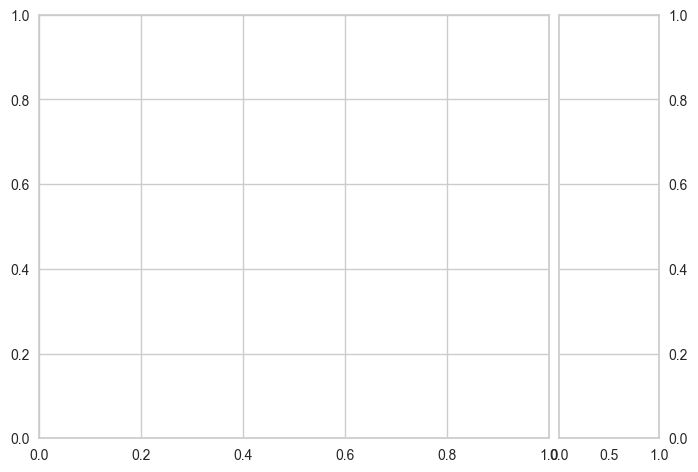

In [ ]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, plot_model

# Step 1: Load the Cleaned Dataset
file_path = '../Data/Required Data/11_cleaned.csv'  # Cleaned dataset path
data = pd.read_csv(file_path)

data.drop(columns=['Date'], inplace=True)
# Ensure Discharge is numeric
data['Discharge'] = pd.to_numeric(data['Discharge'], errors='coerce')
  # Drop Date column if not needed

# Step 3: Setup PyCaret Regression Environment
# Only use rows with valid 'Discharge' for training
train_data = data.dropna(subset=['Discharge'])

print("Setting up PyCaret environment...")
regression_setup = setup(
    data=train_data,
    target='Discharge',
    session_id=42,
    normalize=True,        # Normalize features
    feature_selection=True, # Perform feature selection
    log_experiment=False,  # Disable experiment logging
)

# Step 4: Compare Models
print("Comparing models...")
best_model = compare_models()

# Step 5: Tune the Best Model
print("Tuning the best model...")
tuned_model = tune_model(best_model)

# Step 6: Finalize the Model
print("Finalizing the model...")
final_model = finalize_model(tuned_model)

# Step 7: Evaluate Model
# Residual Plot
'''
print("Generating residual plot...")
plot_model(final_model, plot='residuals', save=True)

# Feature Importance Plot
print("Generating feature importance plot...")
plot_model(final_model, plot='feature', save=True)
'''



In [ ]:
# Step 8: Predict Missing Values
# Predict Discharge for rows with missing target values
missing_data = data[data['Discharge'].isnull()]  # Extract rows with missing Discharge

if missing_data.empty:
    print("No missing values to predict.")
else:
    missing_data.drop(columns = ['Discharge'], inplace = True)
    print("Predicting missing values...")

    # Use PyCaret's predict_model to predict missing values
    predicted = predict_model(final_model, data=missing_data)

    # Check for the prediction column and assign values
    if 'prediction_label' in predicted.columns:
        missing_data['Discharge'] = predicted['prediction_label']
    else:
        print(predicted.head())  # Debugging: Show a sample of the output
        raise KeyError("No valid prediction column ('prediction_label') found in the output of predict_model.")

    # Combine predicted rows with the original dataset
    filled_data = pd.concat([train_data, missing_data]).sort_index()

    # Save the filled dataset
    filled_data.to_csv('../Data/Required Data/11_filled.csv', index=False)
    print("Saved the filled dataset as '../Data/Required Data/11_filled.csv'")


In [ ]:
numbers = ['8', '10', '11']
for num in numbers: 
    making_filled_plots(num)